# Test pipeline
1. Create dataset: sequence of preporcessed examples ready to feed to neuralnet 
2. Create dataloader: define how dataset is loaded to neuralnet (batch size, order, computation optimizing ...)
3. Create model : a bunch of matrixes math to transform input tensor to output tensor
4. Training loop:
    + Forward 
    + Calculate loss
    + Backward
    + Monitoring: 
        + Evaluate metrics
        + Logger, back and forth
        + Visualize

# Import necessary packages

In [1]:

import os
import glob
import sys
import random

import matplotlib.pylab as plt
from PIL import Image, ImageDraw

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF

import numpy as np

from sklearn.model_selection import ShuffleSplit




torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

%matplotlib inline


sys.path.insert(0, '..')
from src.models.utils import FaceDataset



# Create a transformer

In [2]:

def resize_img_label(image,label,target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    
    # resize image and label
    image_new = TF.resize(image,target_size)
    return image_new,label

def transformer(image, label, params):
    image,label = resize_img_label(image,label,params["target_size"]) 
    image = TF.to_tensor(image)
    return image, label



# Create Data loader

In [3]:
trans_params_train = {
    "target_size" : (112, 112),
}


trans_params_val={
    "target_size" : (112, 112), 
}

path2data = "/home/Data/appa-real/processed/"



In [4]:
# create data set
train_ds = FaceDataset(path2data + "train.csv", transformer, trans_params_train)
val_ds = FaceDataset(path2data + "valid.csv", transformer, trans_params_val)

print(len(train_ds))
print(len(val_ds))

3995
1500


In [5]:
import matplotlib.pyplot as plt
def show(img,label=None):
    npimg = img.numpy().transpose((1,2,0))
    plt.imshow(npimg)
    if label is not None:
        label = label.view(-1,2)
        for point in label:
            x,y= point
            plt.plot(x,y,'b+',markersize=10)

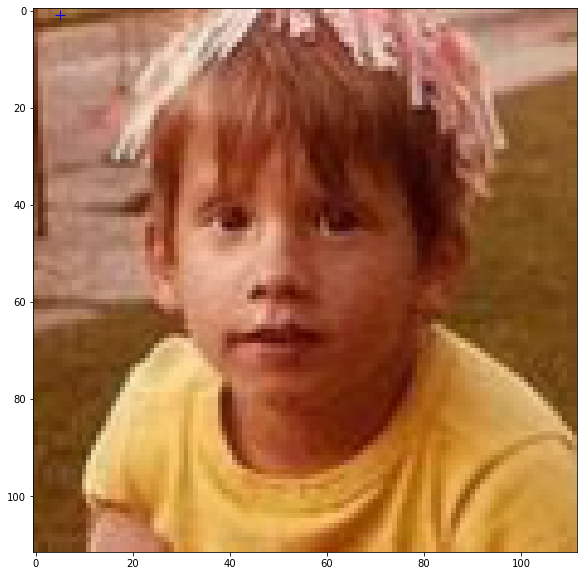

In [6]:

plt.figure(figsize=(10,10))
for img,label in train_ds:
    show(img,label)
    break

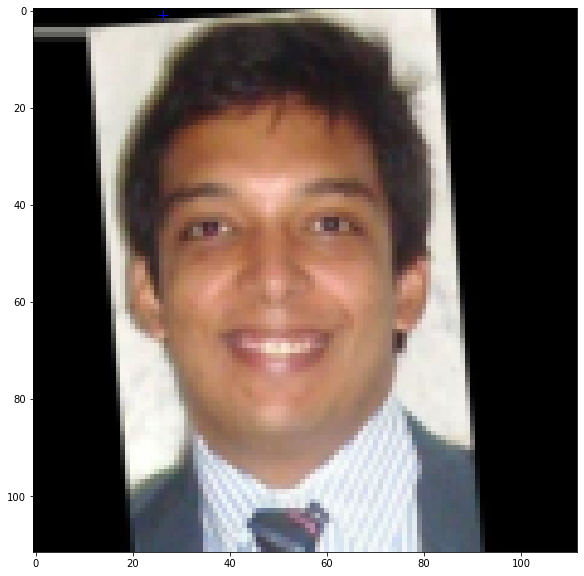

In [7]:
plt.figure(figsize=(10,10))
for img,label in val_ds:
    show(img,label)
    break

In [8]:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size = 32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size = 256, shuffle=False)

In [9]:
for img_b, label_b in train_dl:
    print(img_b.shape,img_b.dtype)
    print(label_b.shape)
    break

torch.Size([32, 3, 112, 112]) torch.float32
torch.Size([32, 2])


In [10]:
for img, label in val_dl:
    print(label.shape)
    break

torch.Size([256, 2])



# Create Model

In [11]:
class Net(nn.Module):
    def __init__(self, params):
        super(Net, self).__init__()
    
    def forward(self, x):
        return x

In [12]:
def __init__(self, params):
    super(Net, self).__init__()

    C_in,H_in,W_in=params["input_shape"]
    init_f=params["initial_filters"] 
    num_outputs=params["num_outputs"] 

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(init_f+C_in, 2*init_f, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(3*init_f+C_in, 4*init_f, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(7*init_f+C_in, 8*init_f, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(15*init_f+C_in, 16*init_f, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(16*init_f, num_outputs)
    self.age_head = nn.Linear(num_outputs, 1)
    self.gender_head = nn.Linear(num_outputs, 1)

In [13]:
def forward(self, x):
    identity=F.avg_pool2d(x,4,4)
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)
    
    identity=F.avg_pool2d(x,2,2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = torch.cat((x, identity), dim=1)

    x = F.relu(self.conv5(x))

    x = F.adaptive_avg_pool2d(x,1)
    x = x.reshape(x.size(0), -1)

    x = F.relu(self.fc1(x))
    
    gender = F.sigmoid(self.gender_head(x))
    age = self.age_head(x)
    
    return age, gender


In [14]:
Net.__init__= __init__
Net.forward = forward

params_model={
        "input_shape": (3,112,112),
        "initial_filters": 64, 
        "num_outputs": 1024,
            }

model = Net(params_model)
device = torch.device("cuda")
model = nn.DataParallel(model)
model = model.to(device)

# Create optimizer

In [15]:
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau


opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10,verbose=1)



# Create custom Performance

In [16]:

from src.models import experiment
from src.models.experiment import Performance

class CustomPerformance(Performance):
    def __init__(self):
        Performance.__init__(self)
        self.gender_loss_func = nn.BCELoss(reduction="sum")
        self.age_loss_func = nn.MSELoss(reduction="sum")
        
    def loss_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        loss_age = self.age_loss_func(age, age_targets)
        
        loss_gender = self.gender_loss_func(gender, gender_targets)
        
        loss = loss_age + loss_gender*10
        
        return loss

    def metrics_function(self, predictions, targets):
        age, gender = predictions
        gender_targets = targets[:, 1].unsqueeze(1)
        age_targets = targets[:, 0].unsqueeze(1)
        
        gender = gender > 0.5
        acc_gender = (gender == gender_targets).sum()
        
        mae_age = torch.abs(age - age_targets).sum()
        
        return torch.tensor([acc_gender, mae_age])


# Training

In [17]:
performance = CustomPerformance()
num_epochs = 20
path2models= "../models/weights.pt"
params = experiment.Prams(num_epochs=num_epochs, path2weights=path2models, device=device,optimizer=opt, lr_scheduler=lr_scheduler, sanity_check=False)

pipeline = experiment.Pipeline(model, train_dl, val_dl, performance, params)
model, performance = pipeline.train_val()


Epoch 0/19, current lr=0.001


/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Copied best model weights!
train loss: 259.565582
val loss: 233.638412
----------
Epoch 1/19, current lr=0.001
Copied best model weights!
train loss: 228.859833
val loss: 211.793503
----------
Epoch 2/19, current lr=0.001
train loss: 223.579468
val loss: 224.892868
----------
Epoch 3/19, current lr=0.001
train loss: 217.069092
val loss: 218.994629
----------
Epoch 4/19, current lr=0.001
Copied best model weights!
train loss: 210.277954
val loss: 199.782333
----------
Epoch 5/19, current lr=0.001
train loss: 197.992294
val loss: 205.015244
----------
Epoch 6/19, current lr=0.001
train loss: 186.694870
val loss: 200.915222
----------
Epoch 7/19, current lr=0.001
Copied best model weights!
train loss: 177.367615
val loss: 181.469101
----------
Epoch 8/19, current lr=0.001
train loss: 167.098175
val loss: 186.485138
----------
Epoch 9/19, current lr=0.001
Copied best model weights!
train loss: 159.455246
val loss: 176.253235
----------
Epoch 10/19, current lr=0.001
Copied best model weight

In [18]:
loss_hist, metrics_history = performance.loss_history, performance.metrics_history
train_hist = torch.stack(metrics_history["train"])
val_hist = torch.stack(metrics_history["val"])

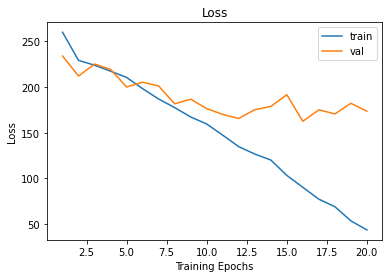

In [19]:
# Train-Validation Progress

# plot loss progress
plt.title("Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

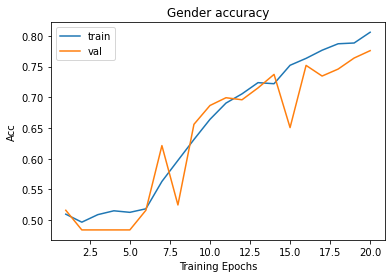

In [20]:
# plot accuracy progress
plt.title("Gender accuracy")
plt.plot(range(1,num_epochs+1),train_hist[:,0], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,0],label="val")
plt.ylabel("Acc")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

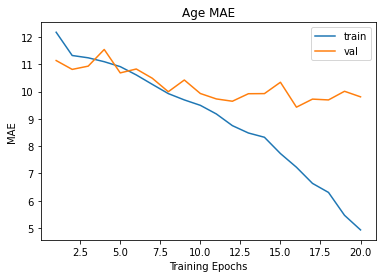

In [21]:
# plot accuracy progress
plt.title("Age MAE")
plt.plot(range(1,num_epochs+1),train_hist[:,1], label="train")
plt.plot(range(1,num_epochs+1),val_hist[:,1],label="val")
plt.ylabel("MAE")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# Testing

In [22]:
test_ds = FaceDataset(path2data + "test.csv", transformer, trans_params_val)

In [23]:
test_dl = DataLoader(test_ds, batch_size = 256, shuffle=False)

In [24]:
loss_test, metrics_test = pipeline.test(test_dl)

/home/duc/anaconda3/envs/torch/lib/python3.8/site-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [25]:
# Gender Accuracy
print(max(train_hist[:,0]))
print(max(val_hist[:,0]))
print(metrics_test[0])

tensor(0.8060)
tensor(0.7760)
tensor(0.7214)


In [26]:
# Age MAE
print(min(train_hist[:,1]))
print(min(val_hist[:,1]))
print(metrics_test[1])

tensor(4.9319)
tensor(9.4302)
tensor(11.3299)


In [27]:
# Loss
print(min(loss_hist["train"]))
print(min(loss_hist["val"]))
print(loss_test)

tensor(43.8919, device='cuda:0', grad_fn=<DivBackward0>)
tensor(162.4216, device='cuda:0')
tensor(234.0130, device='cuda:0')
